# Generates Data for Hierarchical Model Parameter Inference

### The model is a one compartment model with a single subcutaneous dose 

There are three parameters of the structural model ($CL$, $V_c$, $K_a$). The model is defined as

$\dot{x}_{\text{dose}} = -K_a x_{\text{dose}} + \text{DOSE}$

$\dot{x}_{\text{central}} = K_a x_{\text{dose}} - \frac{CL}{V_c} x_{\text{central}}$.

The $x_i$ are given in amount. Only the central compartement is measured in concentration, i.e. $y=x_{\text{central}} / V_c + \varepsilon $, where $\varepsilon $ is some random measurement noise.

Quick forward simulation of individual (without noise)

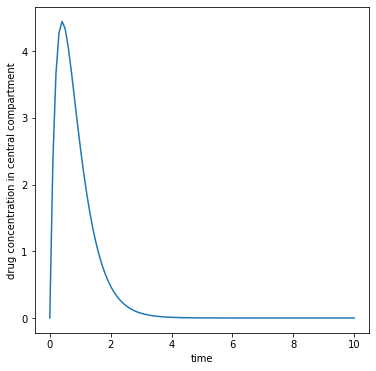

In [2]:
# if you do not have numpy or myokit installed, execute below commands in the terminal
# pip install numpy
# pip install myokit
# pip install matplotlib

import numpy as np
import myokit
import matplotlib.pyplot as plt

# load model
model, protocol, _ = myokit.load('OneCompartmentLinearSc.mmt')

# create simulator
sim = myokit.Simulation(model, protocol)

# define true parameter values (initial drug amount can be fixed to be zero)
cl = 2  # clearance
vc = 1  # volume
ka = 3  # absorption

# dose amount
doseAmount = 10000  # value is arbitrary

# define measurement times
times = np.linspace(0, 10, 100)

# set up simulation
sim.reset()
sim.set_time(0)
sim.set_state([0, 0])  # sets initial drug amounts to zero
sim.set_constant('centralCompartment.CL', cl)
sim.set_constant('centralCompartment.Vc', vc)
sim.set_constant('doseCompartment.Ka', ka)

# only log concentration
loggedVariable = 'centralCompartment.drugConcentration'

# simulate for given dose
sim.set_constant('dose.doseAmount', float(doseAmount))
output = sim.run(times[-1] + 1, log=[loggedVariable], log_times=times)
result = output[loggedVariable]

# visualise simulation
fig = plt.figure(figsize=(6, 6))
plt.plot(times, result)
plt.xlabel('time')
plt.ylabel('drug concentration in central compartment')
plt.show()

Before generating the population data, let's make sure the structural model is identifiable. Let's check this with the package pints. For pints we need to first wrap the model into a pints model, and can then use the pints.SingleOutputProblem to solve it.

Defining pints model

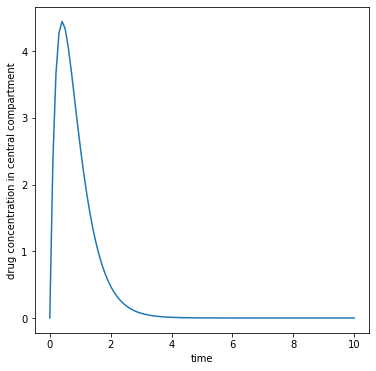

In [3]:
# if you haven't installed pints, execute the below command in the terminal
# git clone https://github.com/pints-team/pints.git
# pip install ./pints
import pints

# define wrap model we had before into a pints model
class PintsModel(pints.ForwardModel):
    def __init__(self):
        # load model
        model, protocol, _ = myokit.load('OneCompartmentLinearSc.mmt')

        # create simulator
        sim = myokit.Simulation(model, protocol)

    def n_parameters(self):
        """
        Number of parameters to fit. Here CL, Vc, Ka
        """
        return 3

    def n_outputs(self):
        return 1

    def simulate(self, parameters, times):
        # set up simulation
        sim.reset()
        sim.set_time(0)
        sim.set_state([0, 0])  # sets initial drug amounts to zero
        cl, vc, ka = parameters
        sim.set_constant('centralCompartment.CL', cl)
        sim.set_constant('centralCompartment.Vc', vc)
        sim.set_constant('doseCompartment.Ka', ka)

        # only log concentration
        loggedVariable = 'centralCompartment.drugConcentration'

        # simulate for given dose
        doseAmount = 10000
        sim.set_constant('dose.doseAmount', float(doseAmount))
        output = sim.run(times[-1] + 1, log=[loggedVariable], log_times=times)
        result = output[loggedVariable]

        return np.array(result)
    
## Check that pints model generates the same data
# create model
model = PintsModel()
times = np.linspace(0, 10, 100)
cl = 2  # clearance
vc = 1  # volume
ka = 3  # absorption
parameters = [cl, vc, ka]

# simulate
result = model.simulate(parameters, times)

# plot
fig = plt.figure(figsize=(6, 6))
plt.plot(times, result)
plt.xlabel('time')
plt.ylabel('drug concentration in central compartment')
plt.show()

In [4]:
print(result)

[ 0.00000000e+00  2.34609489e+00  3.65846151e+00  4.27540907e+00
  4.44341328e+00  4.33349187e+00  4.05954139e+00  3.69990306e+00
  3.30634391e+00  2.91045711e+00  2.53228530e+00  2.18299631e+00
  1.86781268e+00  1.58827292e+00  1.34361799e+00  1.13172115e+00
  9.49722826e-01  7.94472254e-01  6.62789178e-01  5.51625060e-01
  4.58160313e-01  3.79846400e-01  3.14420864e-01  2.59901925e-01
  2.14572123e-01  1.76955549e-01  1.45792481e-01  1.20014314e-01
  9.87176702e-02  8.11441957e-02  6.66591911e-02  5.47310966e-02
  4.49158462e-02  3.68445420e-02  3.02117267e-02  2.47649935e-02
  2.02945964e-02  1.66300311e-02  1.36232287e-02  1.11563298e-02
  9.13276493e-03  7.47457653e-03  6.11710296e-03  5.00624357e-03
  4.09733780e-03  3.35395657e-03  2.74478422e-03  2.24597136e-03
  1.83714867e-03  1.50240726e-03  1.22853358e-03  1.00465285e-03
  8.21611058e-04  6.72056691e-04  5.49610185e-04  4.49404968e-04
  3.67374114e-04  3.00275513e-04  2.45429441e-04  2.00736311e-04
  1.64359377e-04  1.34627

Solving inverse problem

In [5]:
# create inverse problem
problem = pints.SingleOutputProblem(model, times, result)

# create metric to quantify distance from model to data
metric = pints.SumOfSquaresError(problem)

# intial guess of parameters
parameters = [1, 1, 1]

# choose optimisation method
optimiser = pints.CMAES

# create optimisation object
opt = pints.OptimisationController(
    function=metric,
    x0=parameters,
    method=optimiser)

# estimate parameters
estimates, _ = opt.run()

print('Estimates: ', estimates)
print('True values: ', [2, 1, 3])

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7      26.75026   0:00.1
1     14     1.747864   0:00.2
2     21     1.747864   0:00.2
3     28     1.747864   0:00.2
20    147    0.00598    0:00.3
40    287    2.21e-05   0:00.5
60    427    1.51e-08   0:00.6
80    567    5.51e-12   0:00.7
100   707    3.84e-15   0:00.9
120   847    1.48e-16   0:01.0
140   987    6.86e-19   0:01.2
160   1127   7.84e-20   0:01.4
180   1267   9.55e-22   0:01.5
200   1407   2.3e-22    0:01.7
220   1547   1.04e-22   0:01.8
240   1687   1.04e-22   0:02.0
260   1827   1.04e-22   0:02.2
276   1932   1.04e-22   0:02.3
Halting: No significant change for 200 iterations.
Estimates:  [2. 1. 3.]
True values:  [2, 1, 3]


Note that the above is supposed to crash. It may succeed occasionally, but it is likely to crash because whenever $V_c$ hits zero, we divide by zero and the method breaks.

Since for all parameters negative values don't make any sense anyway, we can just take the logarithms of all parameters and infer those parameters instead. This will ensure that no parameter hits zero and will stabilise the optimisation.

Next try:

Pints model where we now exponentiate the parameter values, i.e. the paraemters passed into the simulation are the log-values.

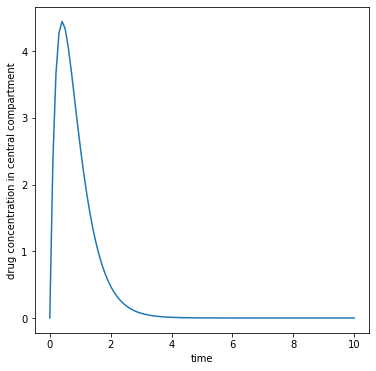

In [6]:
# if you haven't installed pints, execute the below command in the terminal
# git clone https://github.com/pints-team/pints.git
# pip install ./pints
import pints

# define wrap model we had before into a pints model
class PintsModel(pints.ForwardModel):
    def __init__(self):
        # load model
        model, protocol, _ = myokit.load('OneCompartmentLinearSc.mmt')

        # create simulator
        sim = myokit.Simulation(model, protocol)

    def n_parameters(self):
        """
        Number of parameters to fit. Here CL, Vc, Ka
        """
        return 3

    def n_outputs(self):
        return 1

    def simulate(self, parameters, times):
        # set up simulation
        sim.reset()
        sim.set_time(0)
        sim.set_state([0, 0])  # sets initial drug amounts to zero
        cl, vc, ka = np.exp(parameters)
        sim.set_constant('centralCompartment.CL', cl)
        sim.set_constant('centralCompartment.Vc', vc)
        sim.set_constant('doseCompartment.Ka', ka)

        # only log concentration
        loggedVariable = 'centralCompartment.drugConcentration'

        # simulate for given dose
        doseAmount = 10000
        sim.set_constant('dose.doseAmount', float(doseAmount))
        output = sim.run(times[-1] + 1, log=[loggedVariable], log_times=times)
        result = output[loggedVariable]

        return np.array(result)
    
## Check that pints model generates the same data
# create model
model = PintsModel()
times = np.linspace(0, 10, 100)
cl = np.log(2)  # clearance
vc = np.log(1)  # volume
ka = np.log(3)  # absorption
parameters = [cl, vc, ka]

# simulate
result = model.simulate(parameters, times)

# plot
fig = plt.figure(figsize=(6, 6))
plt.plot(times, result)
plt.xlabel('time')
plt.ylabel('drug concentration in central compartment')
plt.show()

Run optimisation again

In [7]:
# create inverse problem
problem = pints.SingleOutputProblem(model, times, result)

# create metric to quantify distance from model to data
metric = pints.SumOfSquaresError(problem)

# intial guess of parameters
parameters = [1, 1, 1]

# choose optimisation method
optimiser = pints.CMAES

# create optimisation object
opt = pints.OptimisationController(
    function=metric,
    x0=parameters,
    method=optimiser)

# estimate parameters
estimates, _ = opt.run()

print('Estimates: ', np.exp(estimates))
print('True values: ', [2, 1, 3])

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7      22.65433   0:00.0
1     14     12.93618   0:00.1
2     21     9.323151   0:00.1
3     28     1.117051   0:00.1
20    147    0.0144     0:00.3
40    287    7.58e-05   0:00.4
60    427    1.77e-07   0:00.6
80    567    6.07e-11   0:00.7
100   707    3.23e-14   0:00.9
120   847    7.58e-17   0:01.1
140   987    6.17e-19   0:01.2
160   1127   2.21e-19   0:01.3
180   1267   3.64e-21   0:01.5
200   1407   5.98e-22   0:01.7
220   1547   8.42e-23   0:01.8
240   1687   3.05e-23   0:02.0
260   1827   3.05e-23   0:02.1
280   1967   1.3e-23    0:02.3
286   2002   1.3e-23    0:02.3
Halting: No significant change for 200 iterations.
Estimates:  [2. 1. 3.]
True values:  [2, 1, 3]


Great! That seems to work.

To now simulate individuals, we basically just need to plug in different parameters into the model and we are done! But if we just plugged in arbitrary values, we would neglect any interdependence we may expect from individuals in a true population. So let's instead assume that there are (fixed) population values for the parameters, i.e. ($CL_{\text{pop}}$, $V_{c,\text{pop}}$, $K_{a, \text{pop}})$, which are also called *fixed effects*, and individual fluctations around those $(\eta _{i, CL}, \eta _{i, V}, \eta _{i, K})$, which are called *random effects*. The individual parameters are hence given by

$CL_i = CL_{\text{pop}} + \eta _{i, CL}$

$V_{c,i} = V_{c,\text{pop}} + \eta _{i, V}$

$K_{a,i} = K_{a, \text{pop}} + \eta _{i, K}$,

where the fixed population paprameter is the same for all individuals $i$, but the random effects vary between the individuals. As the name suggests are the $\eta $ "random", and should therefore be modelled as random variables. The choice of distribution to model the $\eta$ will define the population level model, and makes our model *hierarchical*. 

In our case, let's model the $\eta $ by normal variables, i.e.

$\eta _{CL} \sim \mathcal{N}(0, \Omega ^2_{CL})$

$\eta _{V} \sim \mathcal{N}(0, \Omega ^2_{V})$

$\eta _{K} \sim \mathcal{N}(0, \Omega ^2_{K})$,

where this notation means that the $\eta $ follow the distribution specified by the normal distribution centered around zero and variance $\Omega ^2$. Note that any individual random effect, say $\eta _{CL,i}$ is now considered to be one specific realisation of $\mathcal{N}(0, \Omega ^2_{CL})$. The full model is then given by the above expressions for the individual parameters and

$\dot{x}_{\text{dose}} = -K_{a,i} x_{\text{dose}} + \text{DOSE}$

$\dot{x}_{\text{central}} = K_{a,i} x_{\text{dose}} - \frac{CL_i}{V_{c,i}} x_{\text{central}}$

$y_i = \frac{x_{\text{central}}}{V_{c,i}} + \varepsilon$.

As mentioned above, is $\varepsilon $ modelling the measurement noise, and should therefore also be a random variable. The choice of distribution completes our model. Let's for simplicity also choose a normal distribution centered around zero with constant variance across individuals, $\varepsilon \sim \mathcal{N}(0,\sigma ^2) $. The same noise distribution across individuals would mean that think the measurements were performed under the same conditions for all individuals. This is the representation of the model in terms of it's fixed and random effects.

Alternatively, we can introduce a somewhat more abstract, but therefore shorter notation by grouping the system of ODEs into one function $f(CL, V_c, K_a)$ with the output $y$, i.e.


$\dot{x}_{\text{dose}} = -K_a x_{\text{dose}} + \text{DOSE}$

$\dot{x}_{\text{central}} = K_a x_{\text{dose}} - \frac{CL}{V_c} x_{\text{central}}$

$y = \frac{x_{\text{central}}}{V_{c}}$

becomes

$y = f(CL, V_c, K_a) = \frac{x_{\text{central}}(CL, V_c, K_a)}{V_{c}}$, where in this case the dependence of $x_{\text{central}}$ on the parameters $(CL, V_c, K_a)$ cannot be written down in closed down, but we will solve it numerically. Then with a measurement noise $\varepsilon $ the model can be written as 

$y\sim \mathcal{N}(f(CL, V_c, K_a), \sigma ^2) $

on an individual level. Note that this is really the same as $y = \frac{x_{\text{central}}}{V_{c}} + \varepsilon $, with $\varepsilon \sim \mathcal{N}(0,\sigma ^2) $, as adding a constant just shifts the normal distribution. To make the notation even more shorthand we can lump all structural parameters into one parameter vector $\psi = (CL, V_c, K_a)$ and write 

$y\sim \mathcal{N}(f(\psi ), \sigma ^2) $

The extension to the population level follows by rewriting the fixed and random effects of the indiviual parameters also into a into distriutions, where the fixed effects shift the means from zero to their respective value, i.e.

$CL_i = CL_{\text{pop}} + \eta _{i, CL}$

$V_{c,i} = V_{c,\text{pop}} + \eta _{i, V}$

$K_{a,i} = K_{a, \text{pop}} + \eta _{i, K}$

with 

$\eta _{CL} \sim \mathcal{N}(0, \Omega ^2_{CL})$

$\eta _{V} \sim \mathcal{N}(0, \Omega ^2_{V})$

$\eta _{K} \sim \mathcal{N}(0, \Omega ^2_{K})$

becomes

$CL \sim \mathcal{N}(CL_{\text{pop}}, \Omega ^2_{CL})$

$V_{c} \sim \mathcal{N}(V_{c,\text{pop}}, \Omega ^2_{V})$

$K_{a} \sim \mathcal{N}(K_{a, \text{pop}}, \Omega ^2_{K})$.

So to simulate an individual we would draw a realistion from $\mathcal{N}(CL_{\text{pop}}, \Omega ^2_{CL})$, $\mathcal{N}(V_{c,\text{pop}}, \Omega ^2_{V})$ and $\mathcal{N}(K_{a, \text{pop}}, \Omega ^2_{K})$ and obtain an individual parameter set $(CL_i, V_{c,i}, K_{a,i})$, which we can then use to generate the individual data by drawing a realisation from $\mathcal{N}(f(CL_i, V_{c,i}, K_{a,i}), \sigma ^2)$. So in other words, conditional on the parameter values $(CL_i, V_{c,i}, K_{a,i})$, we can draw the individual data. Going back to the shorthand notation $\psi = (CL, V_c, K_a)$, and also lumping all constant paramters into one paramter vector $\theta = (\sigma , CL_{\text{pop}}, \Omega _{CL}, V_{c,\text{pop}}, \Omega _{V}, K_{a, \text{pop}}, \Omega _{K})$, we can write the full model as brief as 

$p(y,\psi ;\theta ) = p(y|\psi ;\theta )p(\psi ;\theta)$,

where $p(y|\psi ;\theta )$ is the pdf of $\mathcal{N}(f(\psi ), \sigma ^2)$ and $p(\psi ;\theta)$ a shorthand notation for the pdf of

$CL \sim \mathcal{N}(CL_{\text{pop}}, \Omega ^2_{CL})$

$V_{c} \sim \mathcal{N}(V_{c,\text{pop}}, \Omega ^2_{V})$

$K_{a} \sim \mathcal{N}(K_{a, \text{pop}}, \Omega ^2_{K})$.


So to simulate a population, we fix the values of $\theta = (\sigma , CL_{\text{pop}}, \Omega _{CL}, V_{c,\text{pop}}, \Omega _{V}, K_{a, \text{pop}}, \Omega _{K})$ and draw a number of samples from the distribution. Let's for simplicity again set the measurement noise to zero, i.e. $\sigma  = 0$.

Visualisation of individual fluctuations around population parameters.
### Remark: Let the parameters actually be log-normally distributed, i.e. their log-values are normally distributed

$\log CL \sim \mathcal{N}(\log CL_{\text{pop}}, \Omega ^2_{CL})$

$\log V_{c} \sim \mathcal{N}(\log V_{c,\text{pop}}, \Omega ^2_{V})$

$\log K_{a} \sim \mathcal{N}(\log K_{a, \text{pop}}, \Omega ^2_{K})$.

This is simply because we feed the log-values into the algorithm (as this made the inference more stable).

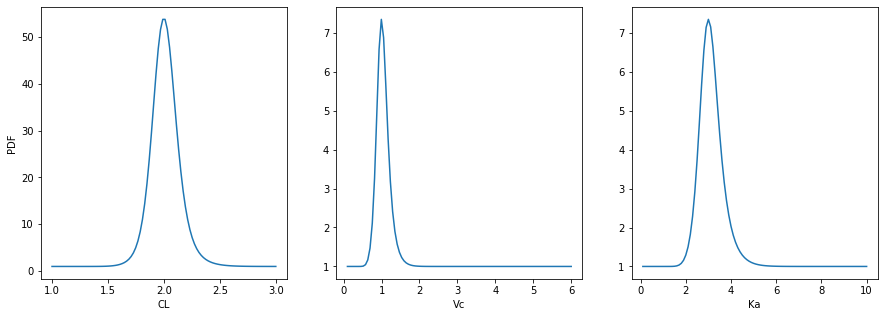

In [8]:
# Let us visualise the population distribution of the parameters

# define population parameters
logCL = np.log(2)
omegaCL = 0.1
logV = np.log(1)
omegaV = 0.2
logK = np.log(3)
omegaK = 0.2

def normalPDF(x, mu, var):
    return np.exp( - (x - mu)**2 / (2 * var))/ np.sqrt(2 * np.pi * var) 

# plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# CL
CL = np.log(np.linspace(1, 3, 100))
ax[0].plot(np.exp(CL), np.exp(normalPDF(CL, logCL, omegaCL ** 2)))
ax[0].set_xlabel('CL')
ax[0].set_ylabel('PDF')

# Vc
V = np.log(np.linspace(0.1, 6, 100))
ax[1].plot(np.exp(V), np.exp(normalPDF(V, logV, omegaV ** 2)))
ax[1].set_xlabel('Vc')

# Ka
K = np.log(np.linspace(0.1, 10, 100))
ax[2].plot(np.exp(K), np.exp(normalPDF(K, logK, omegaK ** 2)))
ax[2].set_xlabel('Ka')

plt.show()

Those are the distributions that we will use to generate the individuals. The parameters are 

$CL_{\text{pop}} = 2$ 

$\Omega _{CL} = 0.1$ 

$V_{c,\text{pop}} = 1$ 

$\Omega _{V} = 0.2$

$K_{a, \text{pop}} = 3$ 

$\Omega _{K} = 0.2$.

Generating 9 individuals (no measurement noise)

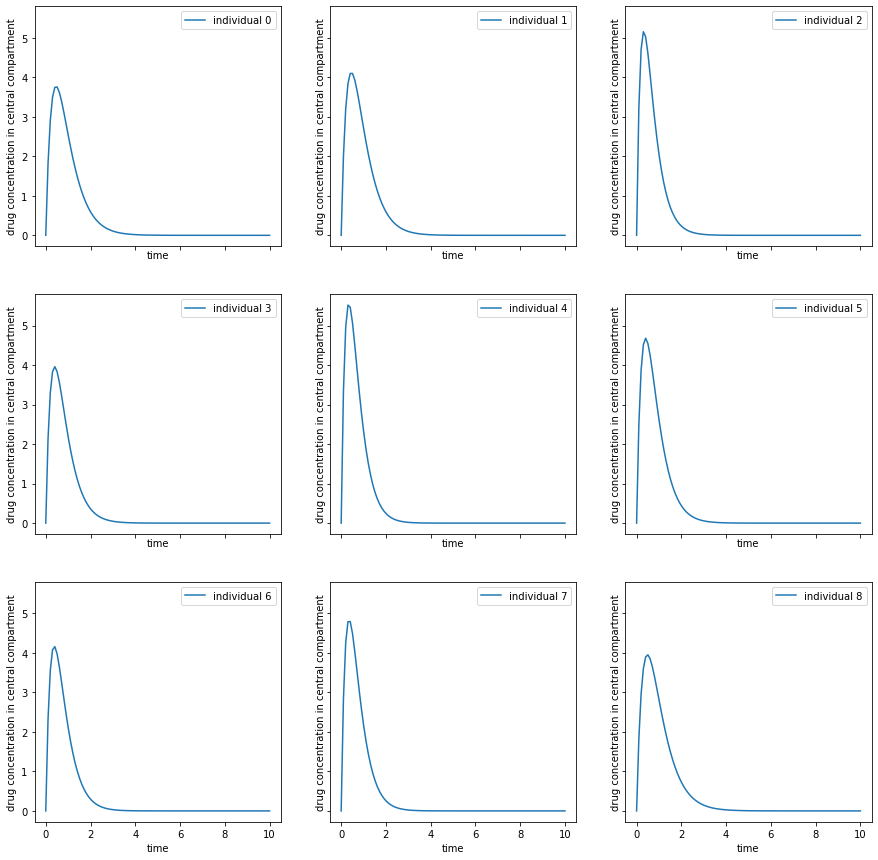

In [9]:
# number individuals
N = 9

# define true parameters
logCL = np.log(2)
omegaCL = 0.1
logV = np.log(1)
omegaV = 0.2
logK = np.log(3)
omegaK = 0.2

# seed pseudo random number, to have reproducible results
np.random.seed(42)

# sample 10 realisations from the 3 distributions above
individualLogCL = np.random.normal(loc=logCL, scale=omegaCL, size=N)
individualLogV = np.random.normal(loc=logV, scale=omegaV, size=N)
individualLogK = np.random.normal(loc=logK, scale=omegaK, size=N)

# chunk parameters together into one container, so we can run sim more easily
parameters = np.array([individualLogCL, individualLogV, individualLogK]).T

# create model
# create model
model = PintsModel()
times = np.linspace(0, 10, 100)

results = []
for individualParameter in parameters:
    results.append(model.simulate(individualParameter, times))
    
# visualise individuals
# plot
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15), sharex=True, sharey=True)

for ID, individual in enumerate(results):
    row = ID // 3
    col = ID % 3

    ax[row, col].plot(times, individual, label='individual %d' % ID)
    ax[row, col].set_xlabel('time')
    ax[row, col].set_ylabel('drug concentration in central compartment')
    ax[row, col].legend()

plt.show()

Hey cool, that looks like population data! Now we just need to add some measurement noise and we are done, i.e. generate some $\varepsilon $.

But before we add that, let's check whether there is also a quick check for the identifiability of the population parameters $\theta = (CL_{\text{pop}}, \Omega _{CL}, V_{c,\text{pop}}, \Omega _{V}, K_{a, \text{pop}}, \Omega _{K})$. Since we just generated the individuals, we know their individual parameters $\psi _i$, and we also know their PDFs $p(\psi |\theta )$. Fortunately, that PDF also defines the likelihood if we consider the $\psi $ as being fixed and the $\theta $ to be the random variable. So as a quick check we can find the maximum likelihood estimates of the populations parameters.

In [10]:
# We can use pints to do this for us, in a somewhat unnecessarily complicated way (in German you would say
# "shooting yourself from behind in the chest"). Anyway, we want the optimisation to return the mean and the 
# variance of the distribution. We can construct GaussianLogLikelihood with pints easily, which will find the
# MLE of the variance for us. We just need the model to reflect the mean. So we basically just implement a 
# model that returns the mean, that we've provided as input. Sounds redundant, but let's see in practice what
# that means.

# define model
class PopulationModel(pints.ForwardModel):
    def n_parameters(self):
        """
        Number of parameters to fit. Here CL, Vc, Ka
        """
        return 1

    def n_outputs(self):
        return 1

    def simulate(self, mean, psi):
        return np.full(fill_value=mean, shape=len(psi))
    
# Instantiate model
popModel = PopulationModel()

# make up times (don't matter here)
times = np.linspace(0, 1, 9)

# Create CL problem
problem = pints.SingleOutputProblem(popModel, times, individualLogCL)
log_likelihood = pints.GaussianLogLikelihood(problem)
opt = pints.OptimisationController(
    function=log_likelihood, 
    x0=[1.5, 1],  # initial guess for mean and variance
    method = pints.CMAES)
estimate, _ = opt.run()

print()
print('Estimate CL: ', np.exp(estimate[0]))
print('True value: ', 2)
print()
print('Estimate Omega CL: ', estimate[1])
print('True value: ', 0.1)
print()

# Create Vc problem
problem = pints.SingleOutputProblem(popModel, times, individualLogV)
log_likelihood = pints.GaussianLogLikelihood(problem)
opt = pints.OptimisationController(
    function=log_likelihood, 
    x0=[1.5, 1],  # initial guess for mean and variance
    method = pints.CMAES)
estimate, _ = opt.run()

print()
print('Estimate V: ', np.exp(estimate[0]))
print('True value: ', 1)
print()
print('Estimate Omega V: ', estimate[1])
print('True value: ', 0.2)
print()

# Create Ka problem
problem = pints.SingleOutputProblem(popModel, times, individualLogK)
log_likelihood = pints.GaussianLogLikelihood(problem)
opt = pints.OptimisationController(
    function=log_likelihood, 
    x0=[1.5, 1],  # initial guess for mean and variance
    method = pints.CMAES)
estimate, _ = opt.run()

print()
print('Estimate K: ', np.exp(estimate[0]))
print('True value: ', 3)
print()
print('Estimate Omega K: ', estimate[1])
print('True value: ', 0.2)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6     -10.18515   0:00.0
1     12     1.733252   0:00.0
2     18     4.89428    0:00.1
3     24     6.84304    0:00.1
20    126    7.49995    0:00.1
40    246    10.8812    0:00.2
60    366    10.88133   0:00.2
80    486    10.88133   0:00.2


/home/simon/anaconda3/envs/bayes/lib/python3.7/site-packages/pints/_log_likelihoods.py:519: RuntimeWarning: invalid value encountered in log
  - np.sum(error**2, axis=0) / (2 * sigma**2))


100   606    10.88133   0:00.2
120   726    10.88133   0:00.2
140   846    10.88133   0:00.3
160   966    10.88133   0:00.3
180   1086   10.88133   0:00.3
200   1206   10.88133   0:00.3
220   1326   10.88133   0:00.3
240   1446   10.88133   0:00.3
260   1566   10.88133   0:00.4
280   1686   10.88133   0:00.4
285   1710   10.88133   0:00.4
Halting: No significant change for 200 iterations.

Estimate CL:  2.089455076664437
True value:  2

Estimate Omega CL:  0.0722245511002995
True value:  0.1

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6     -17.47549   0:00.0
1     12    -14.38379   0:00.0
2     18    -12.50034   0:00.0
3     24    -12.19407   0:00.0
20    126    3.468386   0:00.0
40    246    3.513087   0:00.1
60    366    3.513088   0:00.1
80    486    3.513088   0:00.1
100   606    3.513088   0:00.1
120   726    3.513088   0:00.1
140   846    3.513088   0:00.2
16

The maximum likelihood estimates in that way are the easiest way to recover the population parameters, and we see that it already sort of works. The problem here is that the number of individuals is too low to recover the parameters more accurately. 

Below we can see what happens if we just increase the number of individuals and run the maximum likelihood estimation again.

In [11]:
# number individuals
N = 100

# define true parameters
logCL = np.log(2)
omegaCL = 0.1
logV = np.log(1)
omegaV = 0.2
logK = np.log(3)
omegaK = 0.2

# seed pseudo random number, to have reproducible results
np.random.seed(42)

# sample 10 realisations from the 3 distributions above
individualLogCL = np.random.normal(loc=logCL, scale=omegaCL, size=N)
individualLogV = np.random.normal(loc=logV, scale=omegaV, size=N)
individualLogK = np.random.normal(loc=logK, scale=omegaK, size=N)

# Instantiate model
popModel = PopulationModel()

# make up times (don't matter here)
times = np.linspace(0, 1, N)

# Create CL problem
problem = pints.SingleOutputProblem(popModel, times, individualLogCL)
log_likelihood = pints.GaussianLogLikelihood(problem)
opt = pints.OptimisationController(
    function=log_likelihood, 
    x0=[1.5, 1],  # initial guess for mean and variance
    method = pints.CMAES)
estimate, _ = opt.run()

print()
print('Estimate CL: ', np.exp(estimate[0]))
print('True value: ', 2)
print()
print('Estimate Omega CL: ', estimate[1])
print('True value: ', 0.1)
print()

# Create Vc problem
problem = pints.SingleOutputProblem(popModel, times, individualLogV)
log_likelihood = pints.GaussianLogLikelihood(problem)
opt = pints.OptimisationController(
    function=log_likelihood, 
    x0=[1.5, 1],  # initial guess for mean and variance
    method = pints.CMAES)
estimate, _ = opt.run()

print()
print('Estimate V: ', np.exp(estimate[0]))
print('True value: ', 1)
print()
print('Estimate Omega V: ', estimate[1])
print('True value: ', 0.2)
print()

# Create Ka problem
problem = pints.SingleOutputProblem(popModel, times, individualLogK)
log_likelihood = pints.GaussianLogLikelihood(problem)
opt = pints.OptimisationController(
    function=log_likelihood, 
    x0=[1.5, 1],  # initial guess for mean and variance
    method = pints.CMAES)
estimate, _ = opt.run()

print()
print('Estimate K: ', np.exp(estimate[0]))
print('True value: ', 3)
print()
print('Estimate Omega K: ', estimate[1])
print('True value: ', 0.2)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      6.889263   0:00.0
1     12     6.889263   0:00.0
2     18     6.889263   0:00.0
3     24     51.45459   0:00.0
20    126    98.46104   0:00.1
40    246    98.49959   0:00.1
60    366    98.49972   0:00.1
80    486    98.49972   0:00.1
100   606    98.49972   0:00.1
120   726    98.49972   0:00.2
140   846    98.49972   0:00.2
160   966    98.49972   0:00.2
180   1086   98.49972   0:00.2
200   1206   98.49972   0:00.2
220   1326   98.49972   0:00.3
240   1446   98.49972   0:00.3
260   1566   98.49972   0:00.3
275   1650   98.49972   0:00.3
Halting: No significant change for 200 iterations.

Estimate CL:  1.979338166389434
True value:  2

Estimate Omega CL:  0.09036161737656069
True value:  0.1

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size:

Much better! Ok, we can add some noise to the individual data now and save it as a csv file.

### Generate data

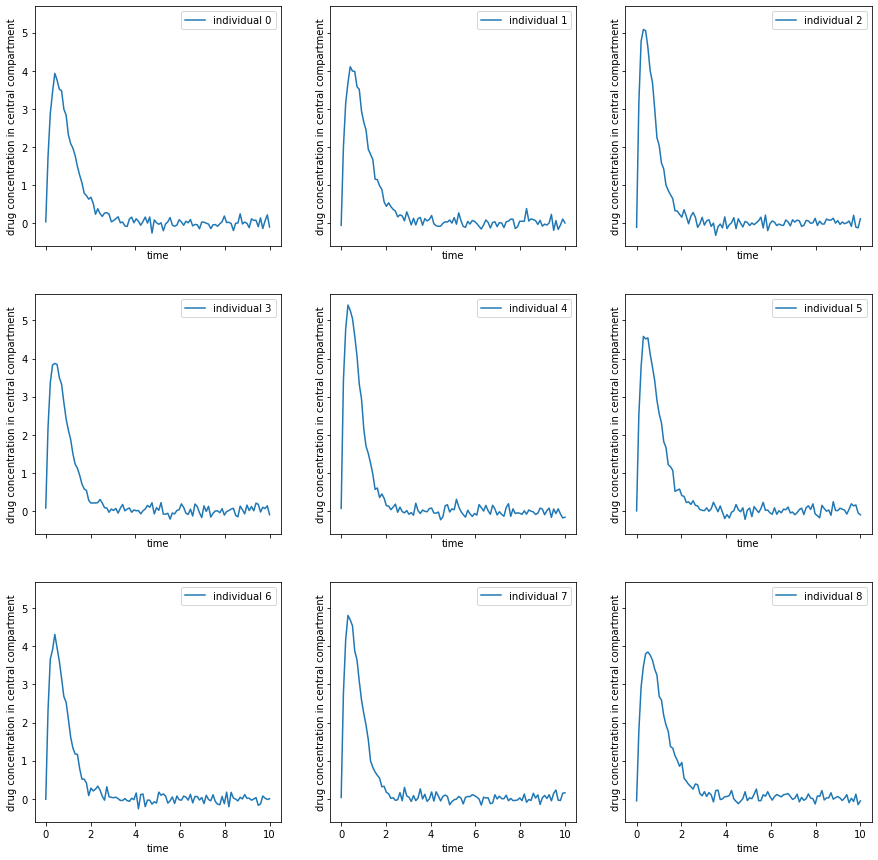

In [12]:
# number individuals
N = 9

# define true parameters
logCL = np.log(2)
omegaCL = 0.1
logV = np.log(1)
omegaV = 0.2
logK = np.log(3)
omegaK = 0.2
sigma = 0.1

# seed pseudo random number, to have reproducible results
np.random.seed(42)

# sample 10 realisations from the 3 distributions above
individualLogCL = np.random.normal(loc=logCL, scale=omegaCL, size=N)
individualLogV = np.random.normal(loc=logV, scale=omegaV, size=N)
individualLogK = np.random.normal(loc=logK, scale=omegaK, size=N)

# chunk parameters together into one container, so we can run sim more easily
parameters = np.array([individualLogCL, individualLogV, individualLogK]).T

# create model
# create model
model = PintsModel()
times = np.linspace(0, 10, 100)

results = []
for individualParameter in parameters:
    results.append(model.simulate(individualParameter, times))

# add noise to data
results = np.array(results)
data = results + np.random.normal(loc=0, scale=sigma, size=results.shape)

# save data to file
fullData = np.concatenate((times[np.newaxis], data), axis=0).T
np.savetxt(X=fullData, fname='data.csv', delimiter=',', header='First column is time, remaining columns are the individuals')
    
# visualise individuals
# plot
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15), sharex=True, sharey=True)

for ID, individual in enumerate(data):
    row = ID // 3
    col = ID % 3

    ax[row, col].plot(times, individual, label='individual %d' % ID)
    ax[row, col].set_xlabel('time')
    ax[row, col].set_ylabel('drug concentration in central compartment')
    ax[row, col].legend()

plt.show()

# Tasks

- Think about ways how to recover the true population parameters from the synthetic data. The true paramters are

$\sigma = 0.1$

$CL_{\text{pop}} = 2$ 

$\Omega _{CL} = 0.1$ 

$V_{c,\text{pop}} = 1$ 

$\Omega _{V} = 0.2$

$K_{a, \text{pop}} = 3$ 

$\Omega _{K} = 0.2$.

- As a first step, you can try to run a similar version of the Maximum Likelihood estimation on the data. The difference now is that we don't know the true individual parameters. So as a crude approximation you can find the maximum likelihood estimate for the indivudals, i.e. use the ODE model and optimise the likelihood as we did just now on the individual data for each individual separately. Then you have and estimiate for the indiviudal paramters $\psi $ and you can run the Maximum Likelihood Estimation on the population parameters again.

- You can then start to think about more robust methods such as a combination of MCMC sampling and optimisation, whatever seems sensible to you, or you can try to implement one of the established algorithms, such as SAEM or Metroplis-Hastings with Gibbs sampling as described in Chons paper.


In [ ]:
def loglikelihood(thetas, y_data, model, times):
    # Parameters 
    # (pop is population level mean, sigma is population variance, then list all individual params)
    # NB. we're keeping sigma fixed because sod it
    CL_pop = 
    CL_omega = 
    CLs = []
    V_pop = 
    V_omega = 
    Vs = 
    K_pop = 
    K_omega = 
    Ks = 
    n_of_individuals = len(Ks)
    
    # Priors
    CL_pop_prior = pints.HalfCauchyLogPrior(1, 5) # Half Cauchy is more directed than uniform prior and excludes <0
    CL_omega_prior = pints.HalfCauchyLogPrior(1, 5)
    CL_prior = pints.GaussianLogPrior(CL_pop, CL_omega)
    
    V_pop_prior = pints.HalfCauchyLogPrior(1, 5)
    V_omega = pints.HalfCauchyLogPrior(1, 5)
    Vs = pints.GaussianLogPrior(V_pop, V_omega)
    
    K_pop_prior = pints.HalfCauchyLogPrior(1, 5)
    K_omega = pints.HalfCauchyLogPrior(1, 5)
    Ks = pints.GaussianLogPrior(K_pop, K_omega)
    
    
    # Model ODEs from given params
    y_model = []
    for n in range(n_of_individuals):
        individual_params = [Cls[n], Vs[n], Ks[n]]
        y_model.append(model.simulate(individual_params, times))
        
    
    # Log likelihood of data
    
    
    
    # Log likelihood of individual parameters
    lk_individual_params = 0
    for n in range(n_of_individuals):
        lk_CL = CL_prior([CLs[n]])
        lk_V = V_prior([Vs[n]])
        lk_K = K_prior([Ks[n]])
        lk_individual_params = lk_individual_params + lk_CL + lk_V + lk_K
    
    
    # Log likelihood of CL
    lk_CL_pop = CL_pop_prior([CL_pop])
    lk_CL_omega = CL_omega_prior([CL_omega])
    
    
    # Log likelihood of V
    lk_V_pop = V_pop_prior([V_pop])
    lk_V_omega = V_omega_prior([V_omega])    
    
    
    # Log likelihood of K
    lk_K_pop = K_pop_prior([K_pop])
    lk_K_omega = K_omega_prior([K_omega])    
    
    sum_log_likelihood = sum([lk_K_pop, lk_K_omega,
                              lk_V_pop, lk_V_omega,
                              lk_CL_pop, lk_CL_omega,
                              lk_individual_params,
                              lk_y
                            ])
    return sum_log_likelihood

3